In [139]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import linregress
from statistics import LinearRegression

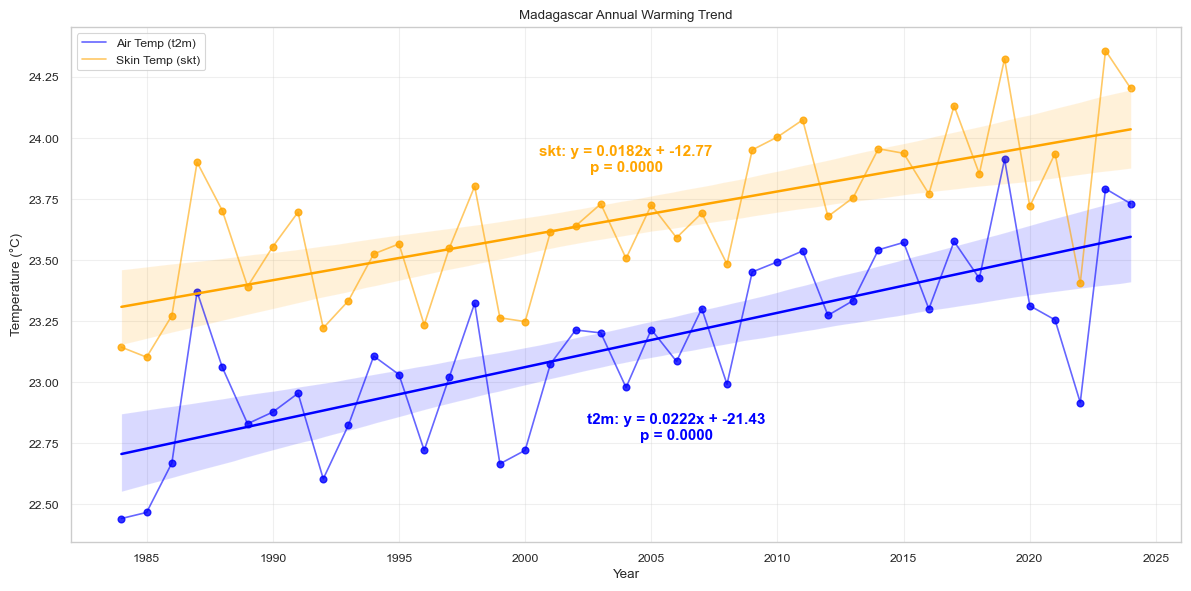

skt: y = 0.0182x + -12.77
p = 0.0000
t2m: y = 0.0222x + -21.43
p = 0.0000


In [140]:

data = pd.read_csv("../output/era5_clean_timeseries.csv")
data['time'] = pd.to_datetime(data['time'])

annual_all = data.groupby(data['time'].dt.year)[['t2m', 'skt']].mean()

years = annual_all.index
t2m = annual_all['t2m']
skt = annual_all['skt']

slope_t2m, intercept_t2m, r_t2m, p_t2m, _ = stats.linregress(years, t2m)
slope_skt, intercept_skt, r_skt, p_skt, _ = stats.linregress(years, skt)

eq_t2m = f"t2m: y = {slope_t2m:.4f}x + {intercept_t2m:.2f}"
eq_skt = f"skt: y = {slope_skt:.4f}x + {intercept_skt:.2f}"

plt.figure(figsize=(12, 6))
sns.lineplot(x=years, y=t2m, color='blue', label=f'Air Temp (t2m)', alpha=0.6)
sns.lineplot(x=years, y=skt, color='orange', label=f'Skin Temp (skt)', alpha=0.6)

sns.regplot(x=years, y=t2m, color='blue')
sns.regplot(x=years, y=skt, color='orange')

x_mid = years.min() + (years.max() - years.min()) / 2

y_t2m_mid = slope_t2m * x_mid + intercept_t2m
y_skt_mid = slope_skt * x_mid + intercept_skt

plt.text(x_mid + 2, y_t2m_mid - 0.4,
         f"{eq_t2m}\np = {p_t2m:.4f}",
         color='blue', fontsize=11, fontweight='bold',
         ha='center', va='bottom')

plt.text(x_mid, y_skt_mid + 0.3,
         f"{eq_skt}\np = {p_skt:.4f}",
         color='orange', fontsize=11, fontweight='bold',
         ha='center', va='top')
# Opis
plt.title("Madagascar Annual Warming Trend")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


print(f"{eq_skt}\np = {p_skt:.4f}")
print(f"{eq_t2m}\np = {p_t2m:.4f}")


In [141]:
start_year = 1984
end_year = 2024
delta_years = end_year - start_year

t2m_increase_trend = slope_t2m * delta_years
skt_increase_trend = slope_skt * delta_years

print(f"T2m trend increase: {t2m_increase_trend:.2f} °C")
print(f"SKT trend increase: {skt_increase_trend:.2f} °C")



t2m_increase = annual_all.loc[end_year, 't2m'] - annual_all.loc[start_year, 't2m']
skt_increase = annual_all.loc[end_year, 'skt'] - annual_all.loc[start_year, 'skt']

print(f"T2m increase (1984–2024): {t2m_increase:.2f} °C")
print(f"SKT increase (1984–2024): {skt_increase:.2f} °C")

T2m trend increase: 0.89 °C
SKT trend increase: 0.73 °C
T2m increase (1984–2024): 1.29 °C
SKT increase (1984–2024): 1.06 °C


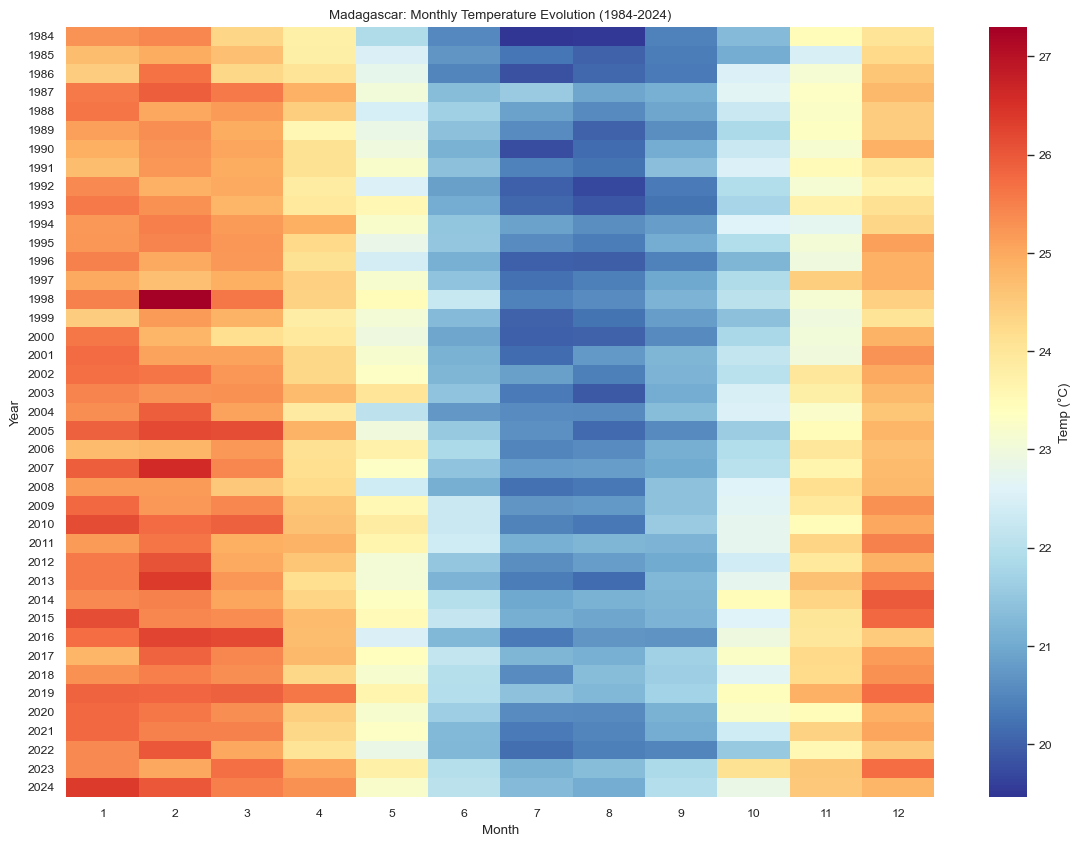

In [142]:
monthly_data = data.set_index('time').resample('MS').mean()


heatmap_data = monthly_data.pivot_table(index=monthly_data.index.year, 
                                        columns=monthly_data.index.month, 
                                        values='t2m')

plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, cmap='RdYlBu_r', annot=False, cbar_kws={'label': 'Temp (°C)'})
plt.title('Madagascar: Monthly Temperature Evolution (1984-2024)')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()

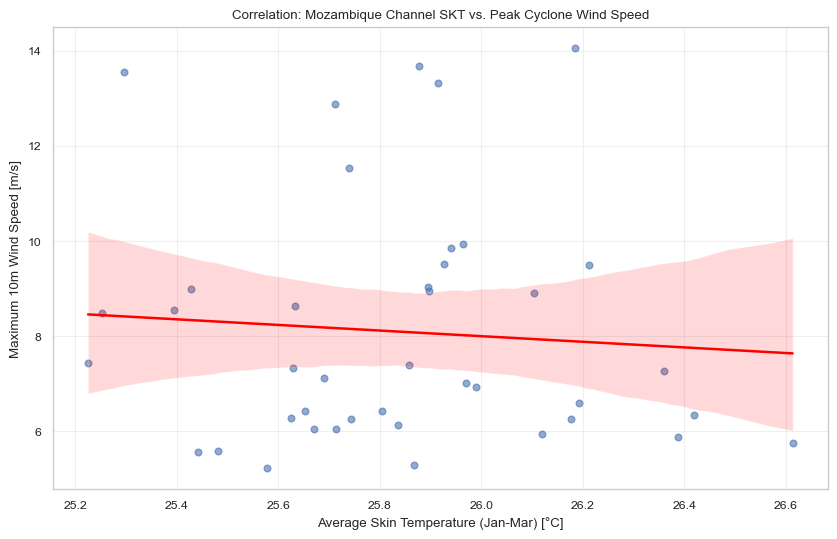

In [143]:
cyclone_season = data[data['time'].dt.month.isin([1, 2, 3])]

q4_analysis = cyclone_season.groupby(cyclone_season['time'].dt.year).agg({
    'skt': 'mean',
    'ws': 'max'
})

plt.figure(figsize=(10, 6))
sns.regplot(data=q4_analysis, x='skt', y='ws', scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
plt.title('Correlation: Mozambique Channel SKT vs. Peak Cyclone Wind Speed')
plt.xlabel('Average Skin Temperature (Jan-Mar) [°C]')
plt.ylabel('Maximum 10m Wind Speed [m/s]')
plt.grid(True, alpha=0.3)
plt.show()

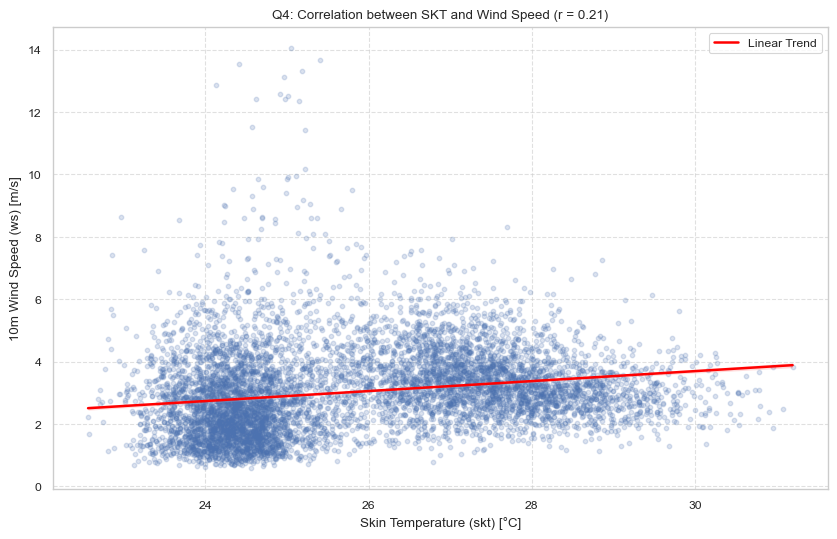

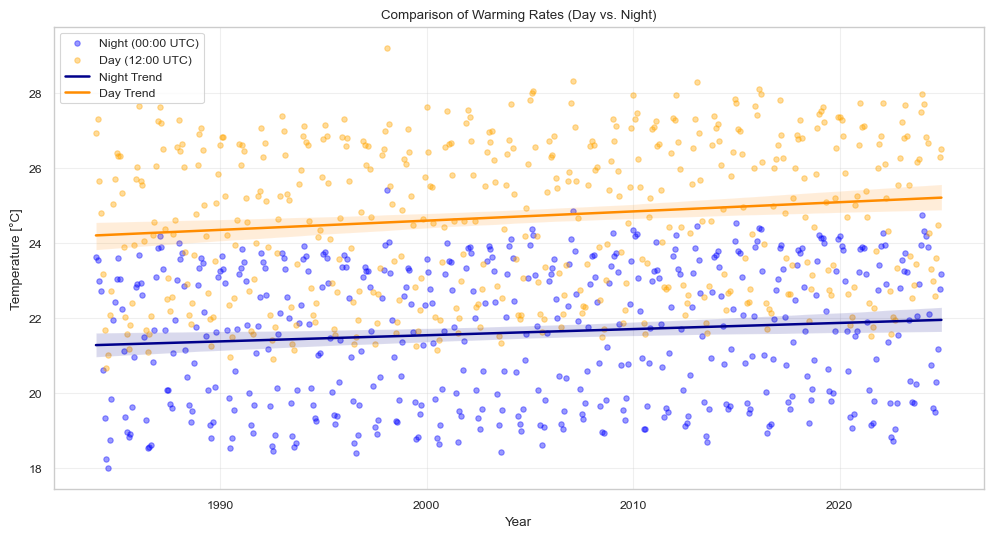

In [144]:


data['time'] = pd.to_datetime(data['time'])

night_df = data[data['time'].dt.hour == 0].copy()
day_df = data[data['time'].dt.hour == 12].copy()
cyclone_months = data[data['time'].dt.month.isin([1, 2, 3])]

plt.figure(figsize=(10, 6))
sns.regplot(data=cyclone_months, x='skt', y='ws', 
            scatter_kws={'alpha': 0.2, 's': 10}, 
            line_kws={'color': 'red', 'label': 'Linear Trend'})
corr, p_val = stats.pearsonr(cyclone_months['skt'], cyclone_months['ws'])

plt.title(f'Q4: Correlation between SKT and Wind Speed (r = {corr:.2f})')
plt.xlabel('Skin Temperature (skt) [°C]')
plt.ylabel('10m Wind Speed (ws) [m/s]')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

monthly_night = night_df.groupby(night_df['time'].dt.to_period('M'))['t2m'].mean().reset_index()
monthly_day = day_df.groupby(day_df['time'].dt.to_period('M'))['t2m'].mean().reset_index()

monthly_night['year_frac'] = monthly_night['time'].dt.year + (monthly_night['time'].dt.month - 1) / 12
monthly_day['year_frac'] = monthly_day['time'].dt.year + (monthly_day['time'].dt.month - 1) / 12

plt.figure(figsize=(12, 6))

plt.scatter(monthly_night['year_frac'], monthly_night['t2m'], 
            alpha=0.4, s=15, color='blue', label='Night (00:00 UTC)')
plt.scatter(monthly_day['year_frac'], monthly_day['t2m'], 
            alpha=0.4, s=15, color='orange', label='Day (12:00 UTC)')

sns.regplot(x='year_frac', y='t2m', data=monthly_night, scatter=False, color='darkblue', label='Night Trend')
sns.regplot(x='year_frac', y='t2m', data=monthly_day, scatter=False, color='darkorange', label='Day Trend')

plt.title('Comparison of Warming Rates (Day vs. Night)')
plt.xlabel('Year')
plt.ylabel('Temperature [°C]')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

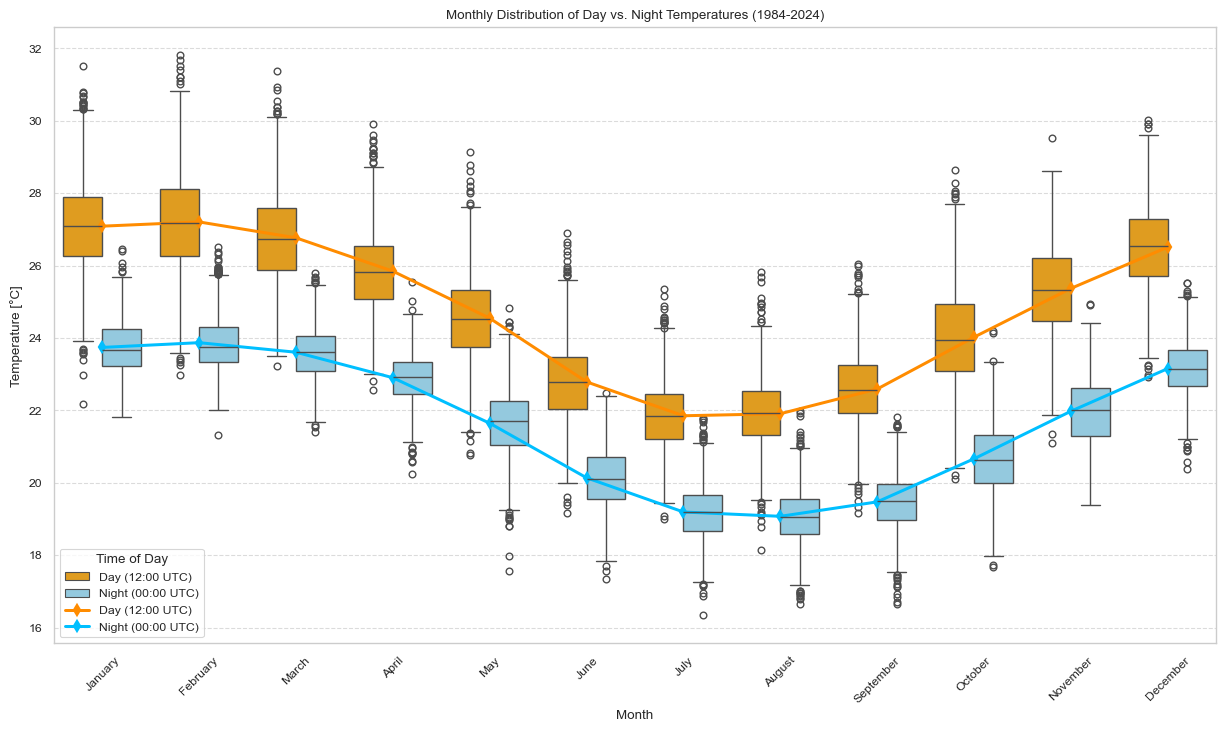

In [145]:
night_df = data[data['time'].dt.hour == 0].copy()
day_df = data[data['time'].dt.hour == 12].copy()

day_data = day_df[['time', 't2m']].copy()
day_data['Period'] = 'Day (12:00 UTC)'

night_data = night_df[['time', 't2m']].copy()
night_data['Period'] = 'Night (00:00 UTC)'
combined_df = pd.concat([day_data, night_data])
combined_df['Month'] = combined_df['time'].dt.month_name()
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=(15, 8))
sns.boxplot(data=combined_df, x='Month', y='t2m', hue='Period', 
            order=month_order, palette={'Day (12:00 UTC)': 'orange', 'Night (00:00 UTC)': 'skyblue'})
sns.pointplot(data=combined_df, x='Month', y='t2m', hue='Period', 
              order=month_order, palette={'Day (12:00 UTC)': 'darkorange', 'Night (00:00 UTC)': 'deepskyblue'},
              markers='d', linestyles='-', errorbar=None)
plt.title('Monthly Distribution of Day vs. Night Temperatures (1984-2024)')
plt.ylabel('Temperature [°C]')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Time of Day')
plt.show()

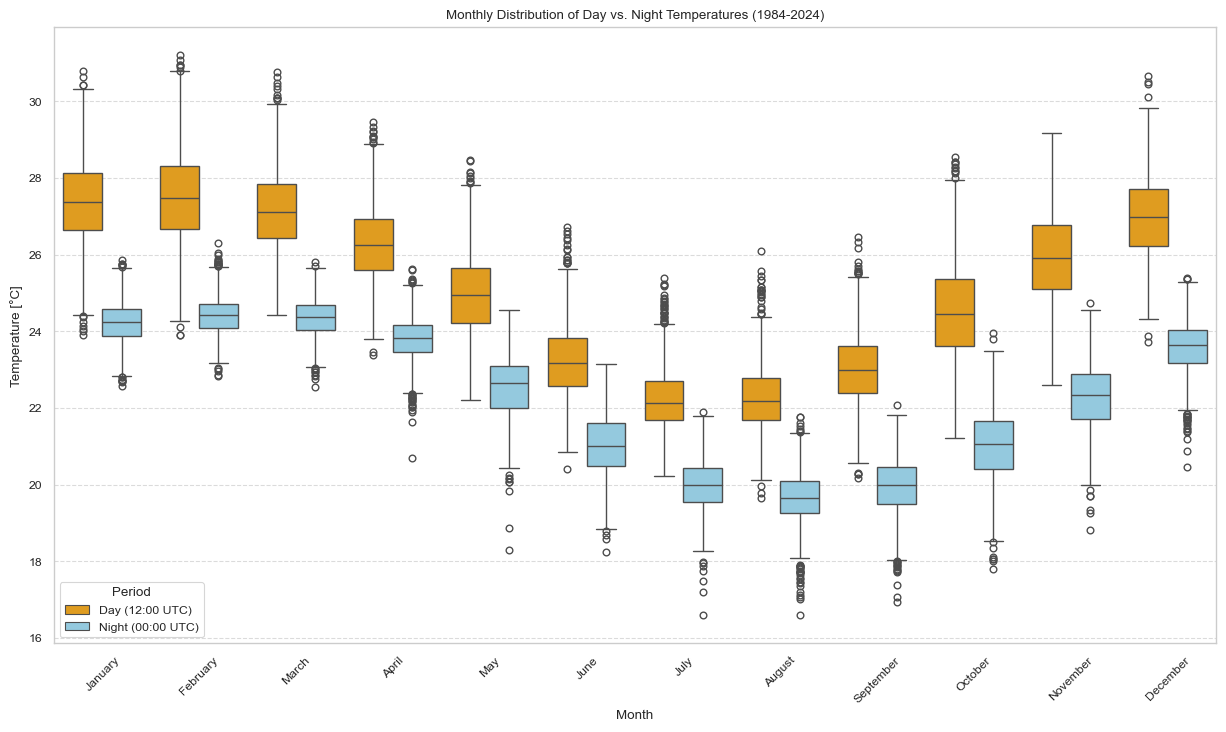

In [146]:
night_monthly = data[data['time'].dt.hour == 0].set_index('time').resample('MS').mean().reset_index()
day_monthly = data[data['time'].dt.hour == 12].set_index('time').resample('MS').mean().reset_index()


day_data = day_df[['time', 'skt']].copy()
day_data['Period'] = 'Day (12:00 UTC)'

night_data = night_df[['time', 'skt']].copy()
night_data['Period'] = 'Night (00:00 UTC)'

combined_df = pd.concat([day_data, night_data])
combined_df['Month'] = combined_df['time'].dt.month_name()

month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=(15, 8))
sns.boxplot(data=combined_df, x='Month', y='skt', hue='Period', 
            order=month_order, palette={'Day (12:00 UTC)': 'orange', 'Night (00:00 UTC)': 'skyblue'})

plt.title('Monthly Distribution of Day vs. Night Temperatures (1984-2024)')
plt.ylabel('Temperature [°C]')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

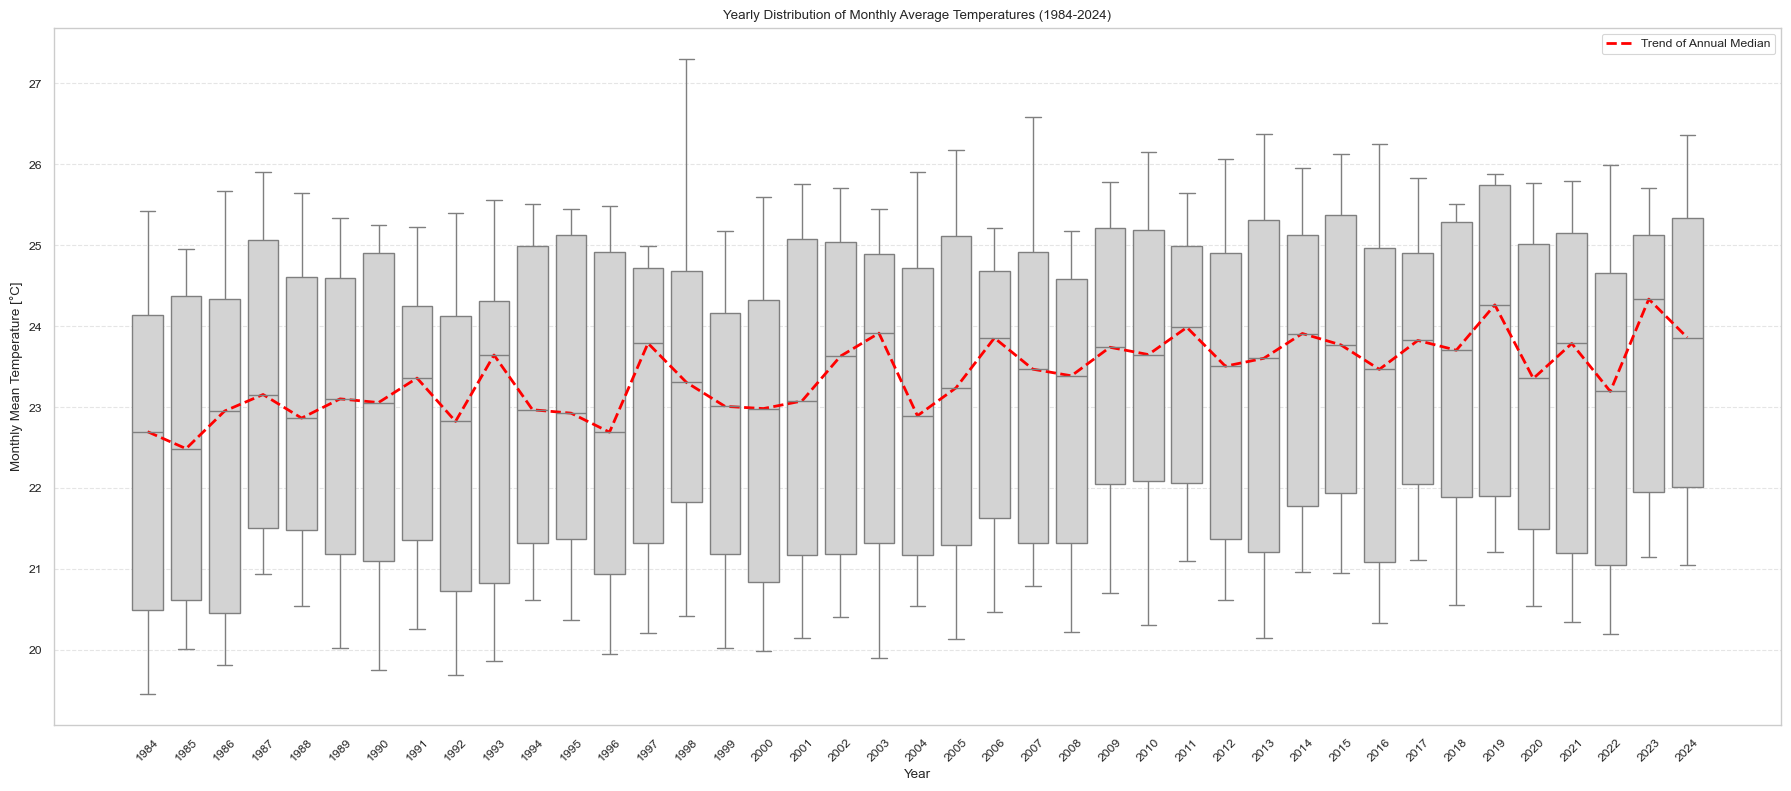

In [147]:


data['time'] = pd.to_datetime(data['time'])

monthly_df = data.set_index('time').resample('MS').mean().reset_index()

monthly_df['Year'] = monthly_df['time'].dt.year

plt.figure(figsize=(18, 8))

sns.boxplot(data=monthly_df, x='Year', y='t2m', color='lightgrey', fliersize=4)

annual_medians = monthly_df.groupby('Year')['t2m'].median()
plt.plot(range(len(annual_medians)), annual_medians.values, color='red', 
         linestyle='--', linewidth=2, label='Trend of Annual Median')

plt.title('Yearly Distribution of Monthly Average Temperatures (1984-2024)')
plt.ylabel('Monthly Mean Temperature [°C]')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

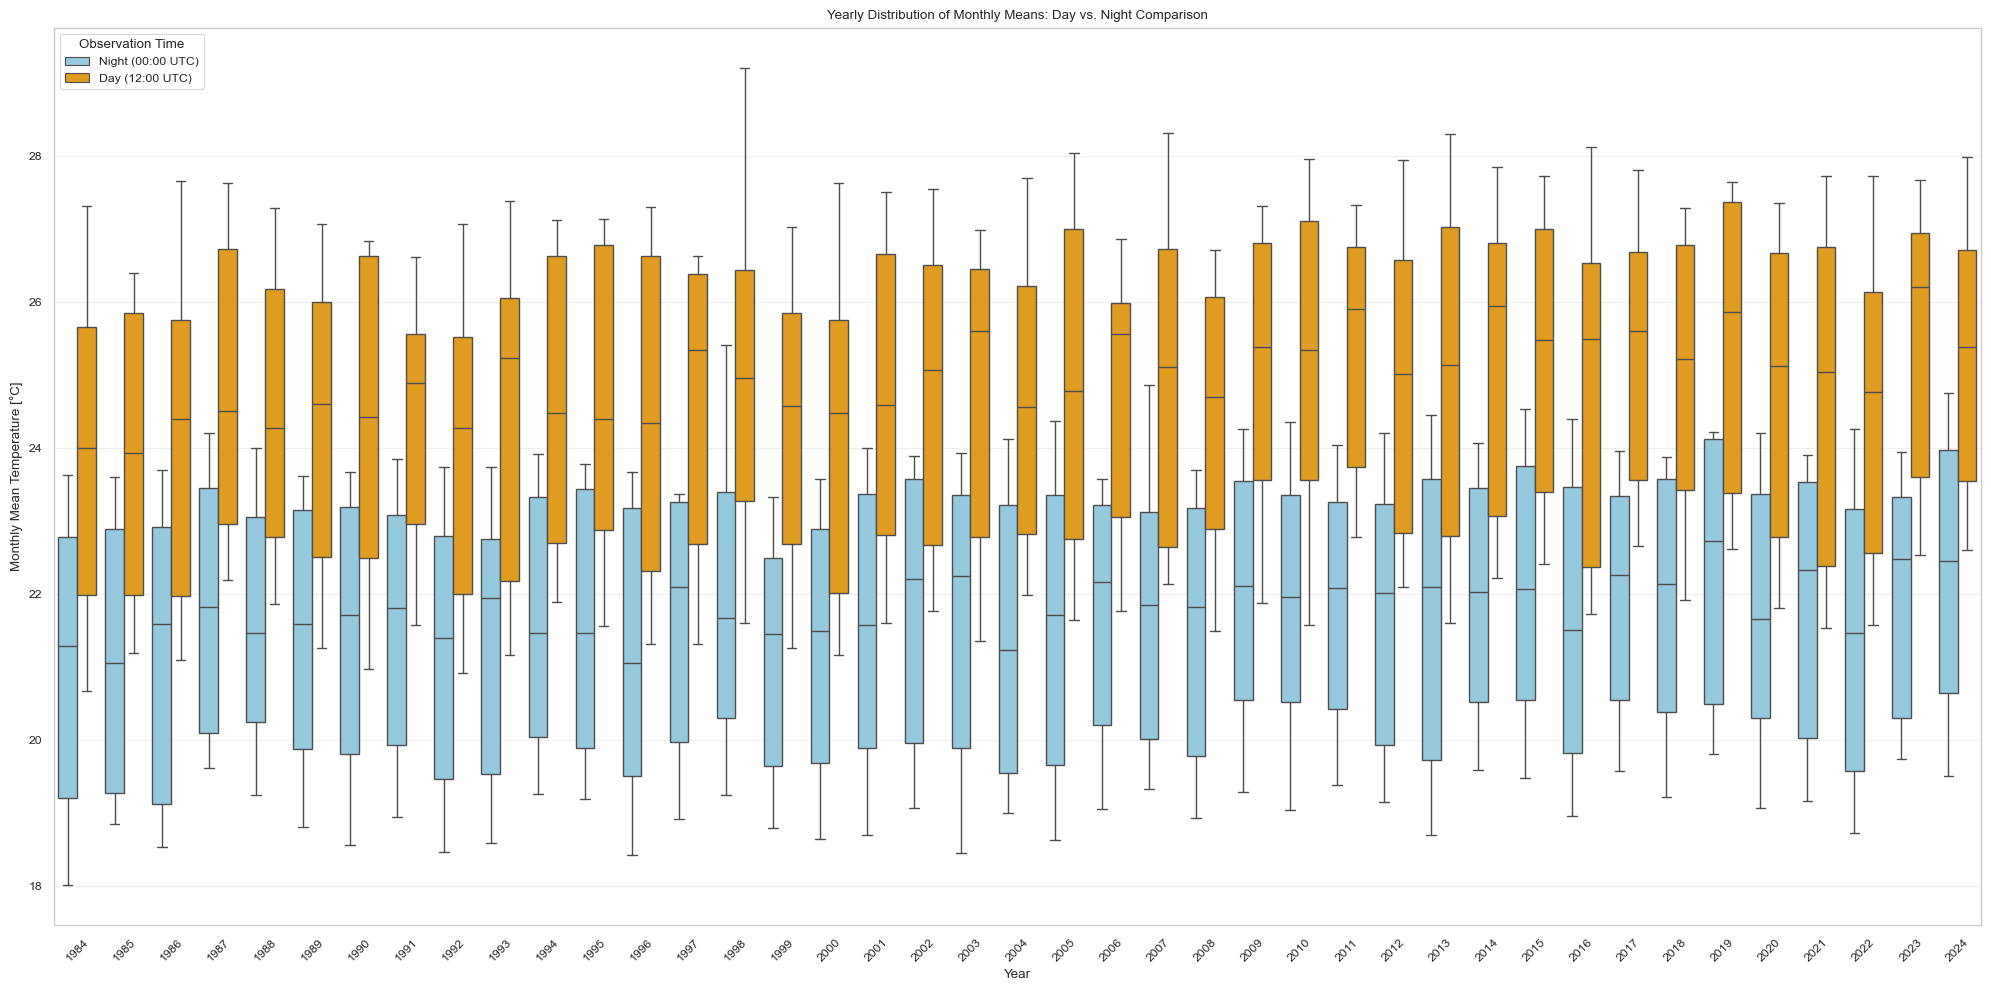

In [148]:
night_monthly = data[data['time'].dt.hour == 0].set_index('time').resample('MS').mean().reset_index()
day_monthly = data[data['time'].dt.hour == 12].set_index('time').resample('MS').mean().reset_index()

night_monthly['Period'] = 'Night (00:00 UTC)'
day_monthly['Period'] = 'Day (12:00 UTC)'
combined_monthly = pd.concat([night_monthly, day_monthly])
combined_monthly['Year'] = combined_monthly['time'].dt.year

plt.figure(figsize=(20, 10))
sns.boxplot(data=combined_monthly, x='Year', y='t2m', hue='Period', 
            palette={'Day (12:00 UTC)': 'orange', 'Night (00:00 UTC)': 'skyblue'},
            fliersize=2)

plt.title('Yearly Distribution of Monthly Means: Day vs. Night Comparison')
plt.ylabel('Monthly Mean Temperature [°C]')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.legend(title='Observation Time', loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

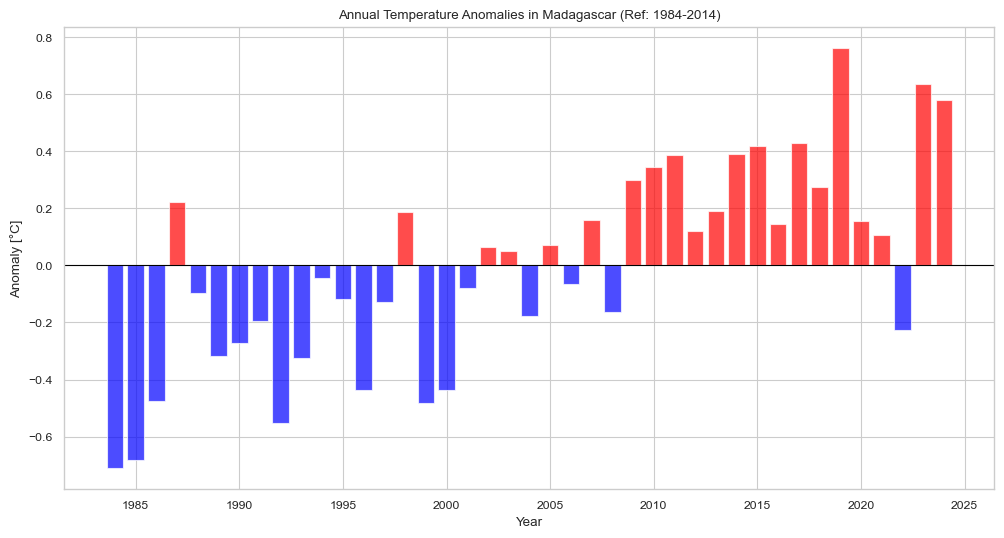

In [149]:
baseline_temp = monthly_df[monthly_df['Year'] <= 2024]['t2m'].mean()
annual_data = monthly_df.groupby('Year')['t2m'].mean().reset_index()
annual_data['anomaly'] = annual_data['t2m'] - baseline_temp
annual_data['color'] = ['red' if x > 0 else 'blue' for x in annual_data['anomaly']]

plt.figure(figsize=(12, 6))
plt.bar(annual_data['Year'], annual_data['anomaly'], color=annual_data['color'], alpha=0.7)
plt.axhline(0, color='black', linewidth=0.8)
plt.title('Annual Temperature Anomalies in Madagascar (Ref: 1984-2014)')
plt.ylabel('Anomaly [°C]')
plt.xlabel('Year')
plt.show()


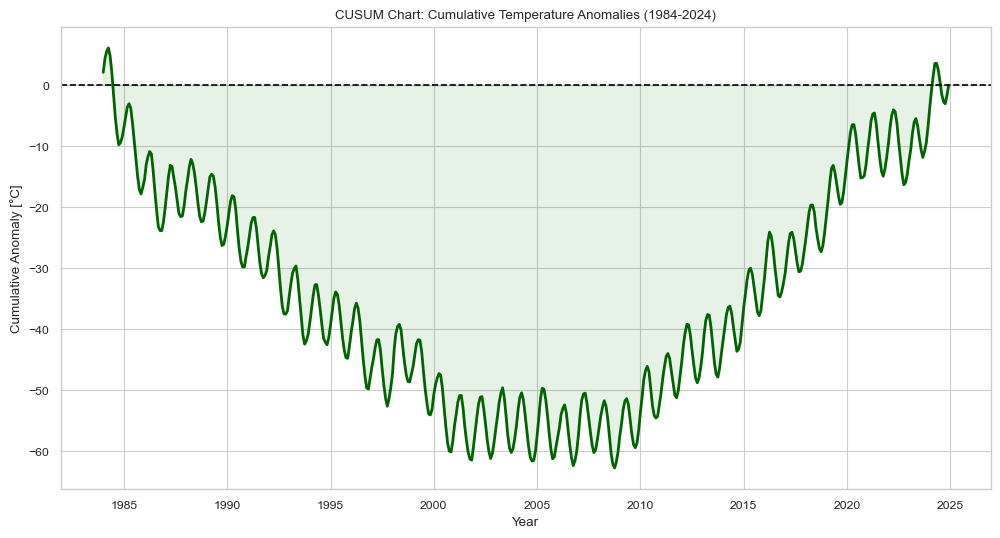

In [150]:

baseline = monthly_df['t2m'].mean()
monthly_df['anomaly'] = monthly_df['t2m'] - baseline
monthly_df['cusum'] = monthly_df['anomaly'].cumsum()

plt.figure(figsize=(12, 6))
plt.plot(monthly_df['time'], monthly_df['cusum'], color='darkgreen', linewidth=2)
plt.axhline(0, color='black', linestyle='--')
plt.title('CUSUM Chart: Cumulative Temperature Anomalies (1984-2024)')
plt.ylabel('Cumulative Anomaly [°C]')
plt.xlabel('Year')
plt.fill_between(monthly_df['time'], monthly_df['cusum'], 0, alpha=0.1, color='green')
plt.show()


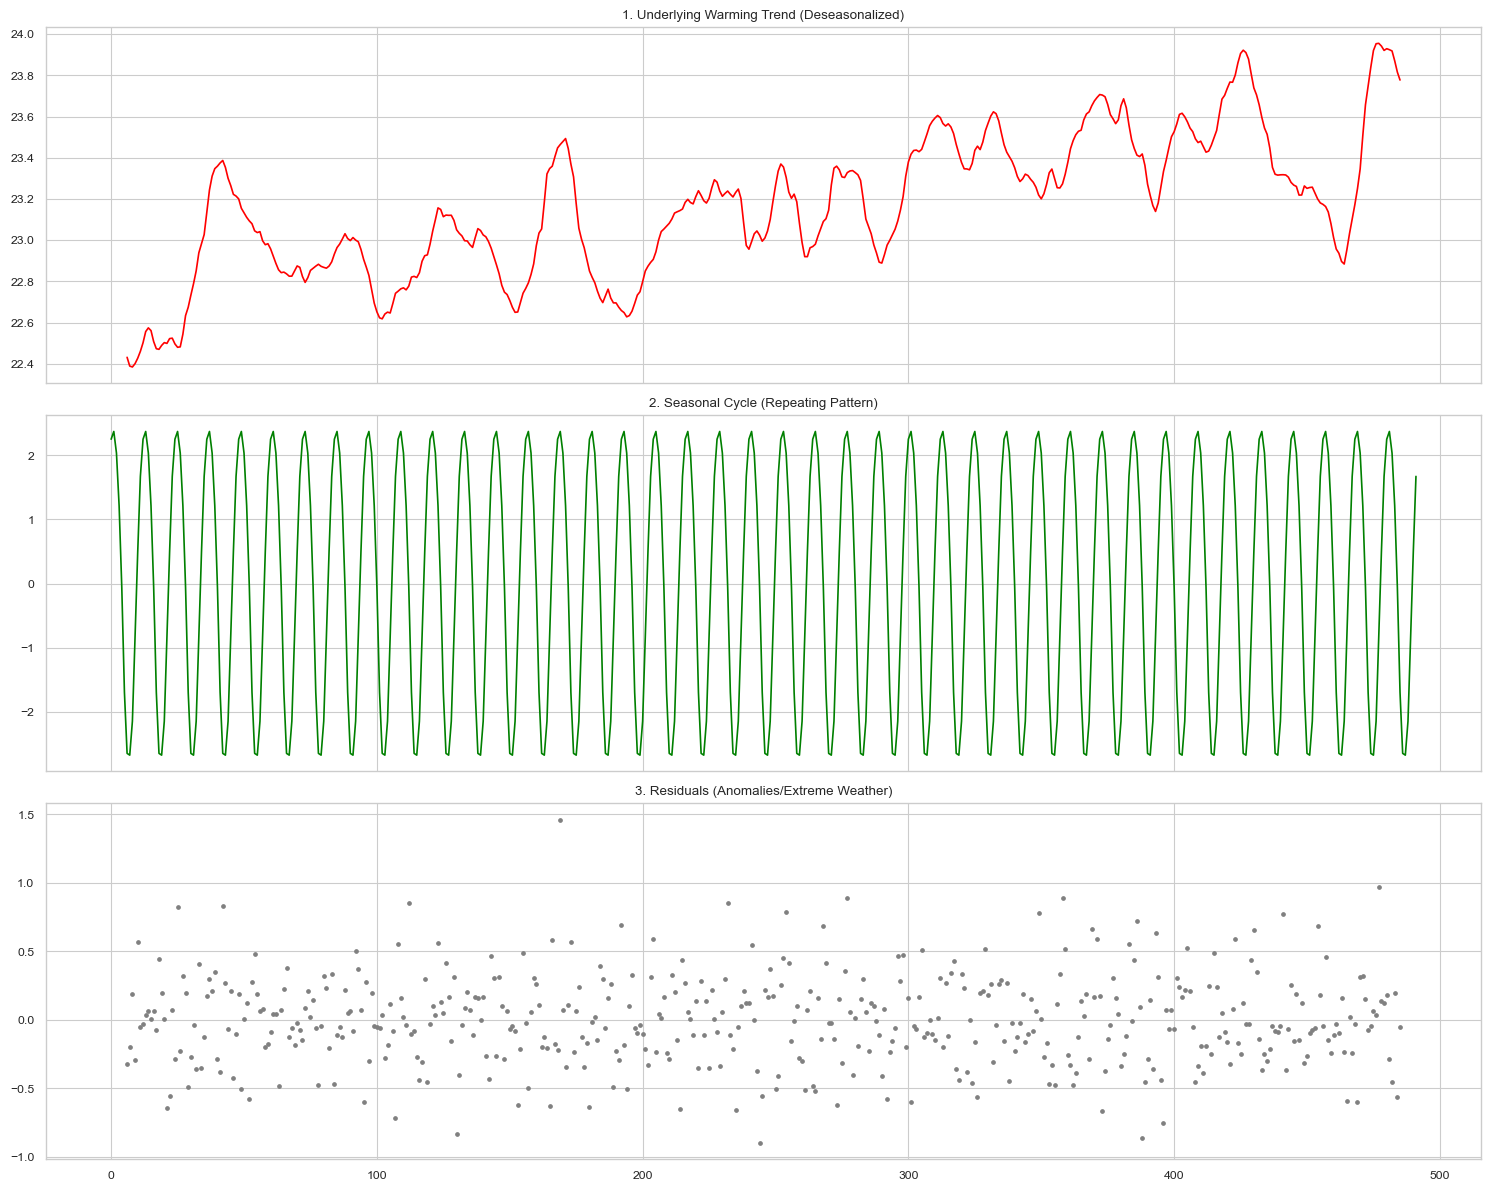

In [151]:


result = seasonal_decompose(monthly_df['t2m'], model='additive', period=12)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
result.trend.plot(ax=ax1, color='red', title='1. Underlying Warming Trend (Deseasonalized)')
result.seasonal.plot(ax=ax2, color='green', title='2. Seasonal Cycle (Repeating Pattern)')
result.resid.plot(ax=ax3, color='gray', style='.', title='3. Residuals (Anomalies/Extreme Weather)')
plt.tight_layout()
plt.show()

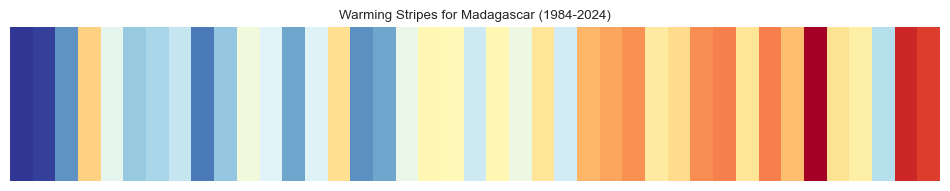

In [152]:
annual_mean = data.groupby(data['time'].dt.year)['t2m'].mean()
anomaly = annual_mean - annual_mean.mean()

fig, ax = plt.subplots(figsize=(12, 2))
sns.heatmap(anomaly.values.reshape(1, -1), cmap='RdYlBu_r', cbar=False, ax=ax, xticklabels=False, yticklabels=False)
plt.title('Warming Stripes for Madagascar (1984-2024)')
plt.show()

In [153]:
def calculate_annual_cdd(daily_tp_series):
    """
    Calculates the maximum Consecutive Dry Days (CDD) per year.
    daily_tp_series should be daily Total Precipitation in mm.
    """
    is_dry = daily_tp_series < 1.0
    
    groups = (is_dry != is_dry.shift()).cumsum()
    
    dry_lengths = is_dry.groupby(groups).sum()
    
    return dry_lengths.max()

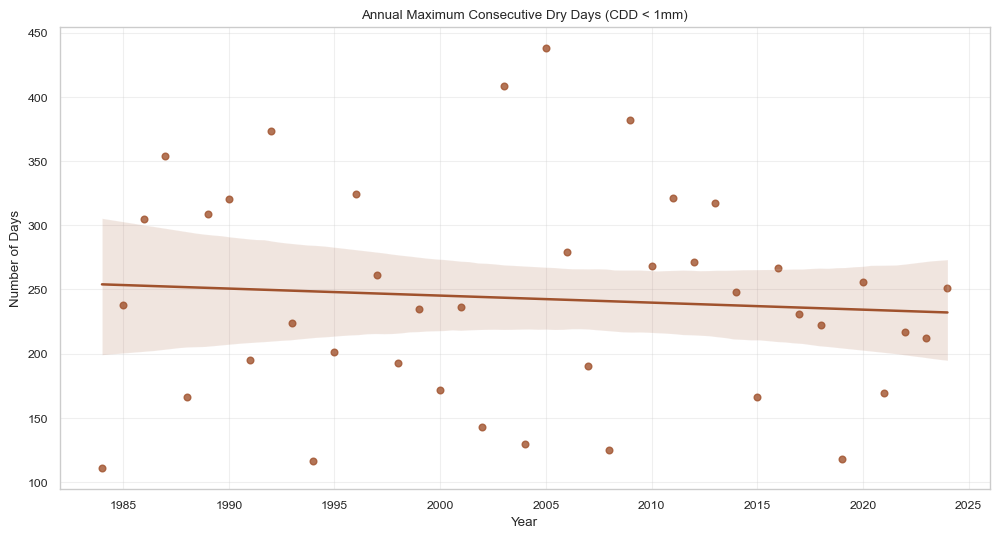

In [154]:

data['time'] = pd.to_datetime(data['time'])

def get_max_cdd(series, threshold=1.0):
    """Calculates the maximum number of consecutive days with rainfall < threshold."""
    is_dry = series < threshold
    return is_dry.groupby((is_dry != is_dry.shift()).cumsum()).sum().max()

annual_cdd = data.groupby(data['time'].dt.year)['tp'].apply(get_max_cdd)

plt.figure(figsize=(12, 6))
sns.regplot(x=annual_cdd.index, y=annual_cdd.values, color='sienna', marker='o')
plt.title('Annual Maximum Consecutive Dry Days (CDD < 1mm)')
plt.ylabel('Number of Days')
plt.xlabel('Year')
plt.grid(True, alpha=0.3)
plt.show()

C:\Users\julka\AppData\Local\Temp\ipykernel_26952\2185474225.py:12: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_cdd = dry_days_int.resample('Y').apply(compute_max_cdd)
C:\Users\julka\AppData\Local\Temp\ipykernel_26952\2185474225.py:14: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_p = daily_tp.resample('Y').sum()
C:\Users\julka\AppData\Local\Temp\ipykernel_26952\2185474225.py:15: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_e = daily_e.resample('Y').sum()


CDD trend: -0.18 days/year, p=0.6365
P/E trend: 0.0002/year, p=0.9544
Water balance trend: 0.12 mm/year, p=0.7291


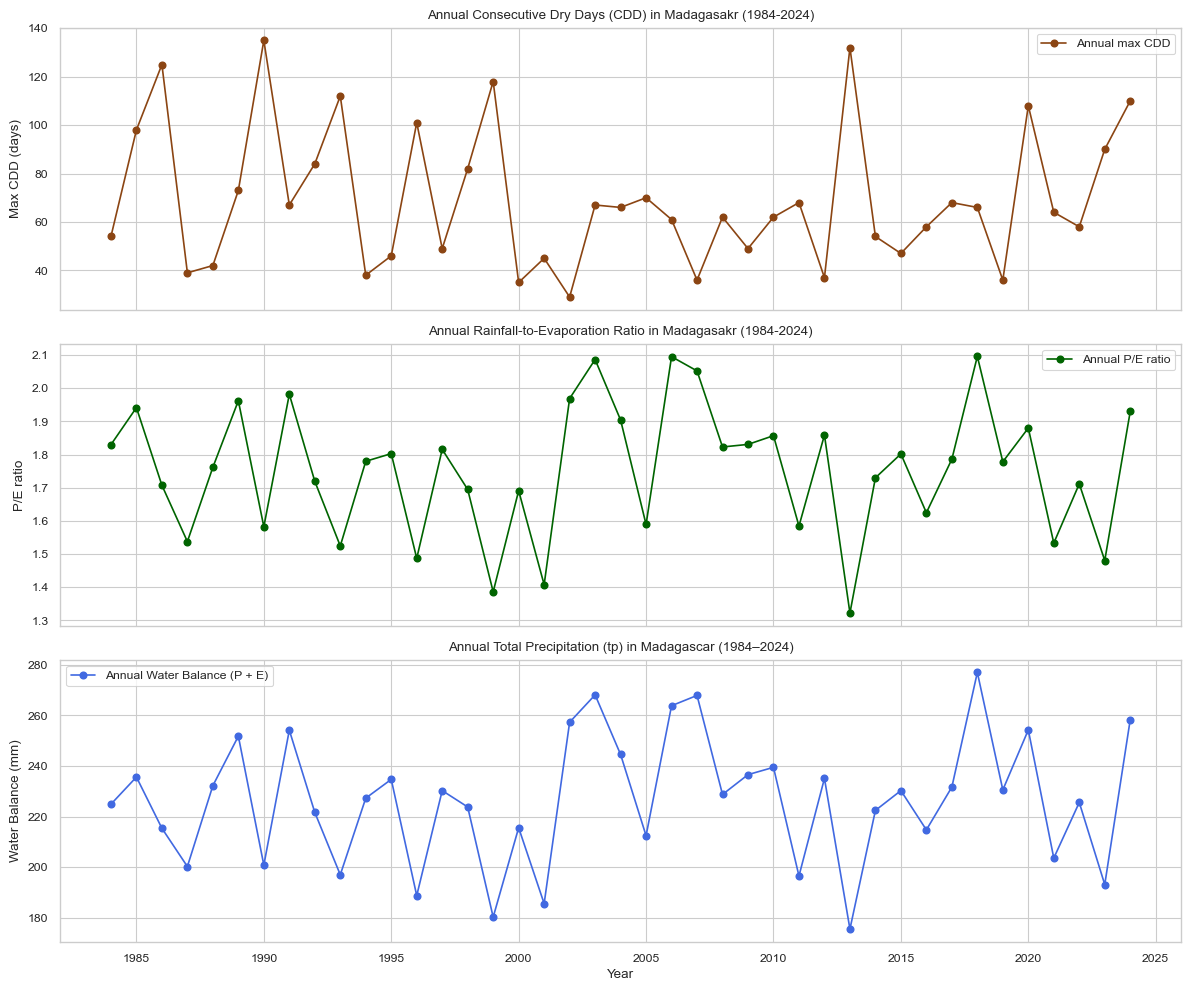

In [ ]:

daily_tp = data['tp'].resample('D').sum()
daily_e = data['e'].abs().resample('D').sum()

dry_days = daily_tp < 1.0
dry_days_int = dry_days.astype(int)

def compute_max_cdd(series):
    """Compute maximum consecutive dry days in a period"""
    cumsum = (~series.astype(bool)).cumsum()
    return series.groupby(cumsum).cumcount().max() + 1

annual_cdd = dry_days_int.resample('Y').apply(compute_max_cdd)

annual_p = daily_tp.resample('Y').sum()
annual_e = daily_e.resample('Y').sum()
annual_pe_ratio = annual_p / annual_e

annual_water_balance = annual_p - annual_e

years = annual_cdd.index.year

slope_cdd, intercept_cdd, r_cdd, p_cdd, std_cdd = linregress(years, annual_cdd.values)
slope_pe, intercept_pe, r_pe, p_pe, std_pe = linregress(years, annual_pe_ratio.values)
slope_wb, intercept_wb, r_wb, p_wb, std_wb = linregress(years, annual_water_balance.values)

print(f"CDD trend: {slope_cdd:.2f} days/year, p={p_cdd:.4f}")
print(f"P/E trend: {slope_pe:.4f}/year, p={p_pe:.4f}")
print(f"Water balance trend: {slope_wb:.2f} mm/year, p={p_wb:.4f}")

fig, ax = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

ax[0].plot(years, annual_cdd.values, color='saddlebrown', marker='o', label='Annual max CDD')
ax[0].set_ylabel('Max CDD (days)')
ax[0].set_title('Annual Consecutive Dry Days (CDD) in Madagasakr (1984-2024)')
ax[0].legend()

ax[1].plot(years, annual_pe_ratio.values, color='darkgreen', marker='o', label='Annual P/E ratio')
ax[1].set_ylabel('P/E ratio')
ax[1].set_title('Annual Rainfall-to-Evaporation Ratio in Madagasakr (1984-2024)')
ax[1].legend()

ax[2].plot(years, annual_p.values, color='royalblue', marker='o', label='Annual Water Balance (P + E)')
ax[2].set_ylabel('Water Balance (mm)')
ax[2].set_xlabel('Year')
ax[2].set_title('Annual Total Precipitation (tp) in Madagascar (1984–2024)')
ax[2].legend()

plt.tight_layout()
plt.show()


C:\Users\julka\AppData\Local\Temp\ipykernel_26952\468128969.py:16: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_cdd = dry_days_int.resample('Y').apply(compute_max_cdd)
C:\Users\julka\AppData\Local\Temp\ipykernel_26952\468128969.py:18: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_p = daily_tp.resample('Y').sum()
C:\Users\julka\AppData\Local\Temp\ipykernel_26952\468128969.py:19: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_e = daily_e.abs().resample('Y').sum()
C:\Users\julka\AppData\Local\Temp\ipykernel_26952\468128969.py:23: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_skt = daily_skt.resample('Y').mean()
C:\Users\julka\AppData\Local\Temp\ipykernel_26952\468128969.py:24: FutureWarning: 'Y' is deprecated and will be removed in a future vers

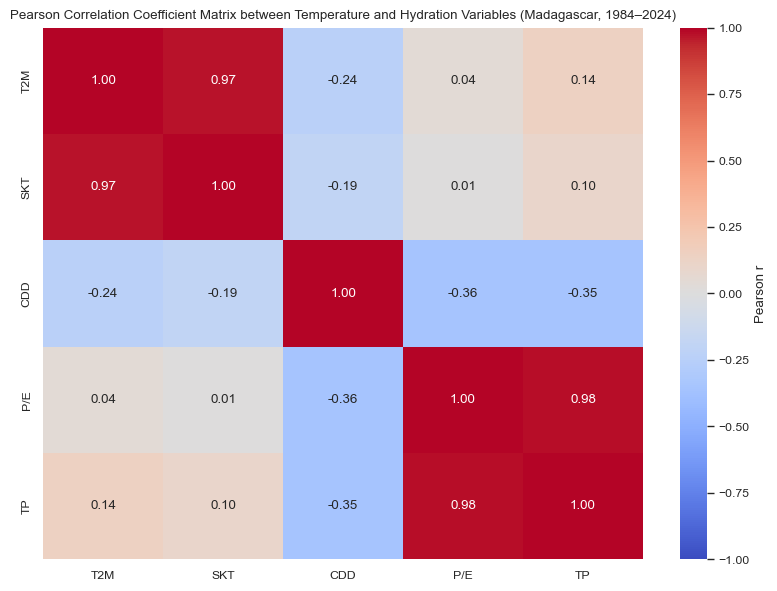

In [168]:

data = pd.read_csv("../output/era5_clean_timeseries.csv", parse_dates=['time'])
data.set_index('time', inplace=True)

daily_tp = data['tp'].resample('D').sum()
daily_e = data['e'].resample('D').sum()
daily_skt = data['skt'].resample('D').mean()
daily_t2m = data['t2m'].resample('D').mean()

dry_days = daily_tp < 1.0
dry_days_int = dry_days.astype(int)

def compute_max_cdd(series):
    cumsum = (~series.astype(bool)).cumsum()
    return series.groupby(cumsum).cumcount().max() + 1

annual_cdd = dry_days_int.resample('Y').apply(compute_max_cdd)

annual_p = daily_tp.resample('Y').sum()
annual_e = daily_e.abs().resample('Y').sum()
annual_pe_ratio = annual_p / annual_e

annual_water_balance = annual_p - annual_e
annual_skt = daily_skt.resample('Y').mean()
annual_t2m = daily_t2m.resample('Y').mean()

annual_df = pd.DataFrame({
    'T2M': annual_t2m.values,
    'SKT': annual_skt.values,
    'CDD': annual_cdd.values,
    'P/E': annual_pe_ratio.values,
    'TP': annual_p.values
}, index=annual_t2m.index)
corr_matrix = annual_df.corr(method='pearson')

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, cbar_kws={'label': 'Pearson r'})
plt.title('Pearson Correlation Coefficient Matrix between Temperature and Hydration Variables (Madagascar, 1984–2024)')
plt.tight_layout()
plt.show()


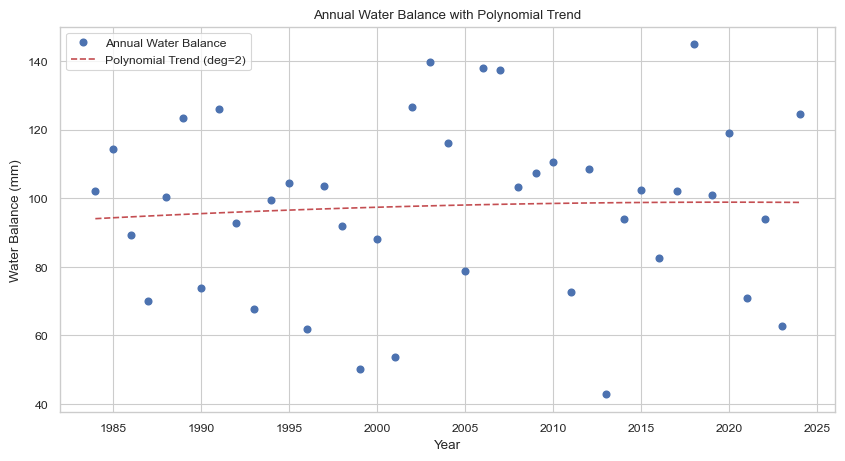

In [169]:

years = annual_water_balance.index.year
wb_values = annual_water_balance.values

coeffs = np.polyfit(years, wb_values, deg=2)

trend_line = np.polyval(coeffs, years)

plt.figure(figsize=(10,5))
plt.plot(years, wb_values, 'o', label='Annual Water Balance')
plt.plot(years, trend_line, 'r--', label='Polynomial Trend (deg=2)')
plt.xlabel('Year')
plt.ylabel('Water Balance (mm)')
plt.title('Annual Water Balance with Polynomial Trend')
plt.legend()
plt.show()


C:\Users\julka\AppData\Local\Temp\ipykernel_26952\2610127349.py:3: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  peak_wind = cyclone_season['ws'].resample('Y').max()
C:\Users\julka\AppData\Local\Temp\ipykernel_26952\2610127349.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  mean_skt = cyclone_season['skt'].resample('Y').mean()


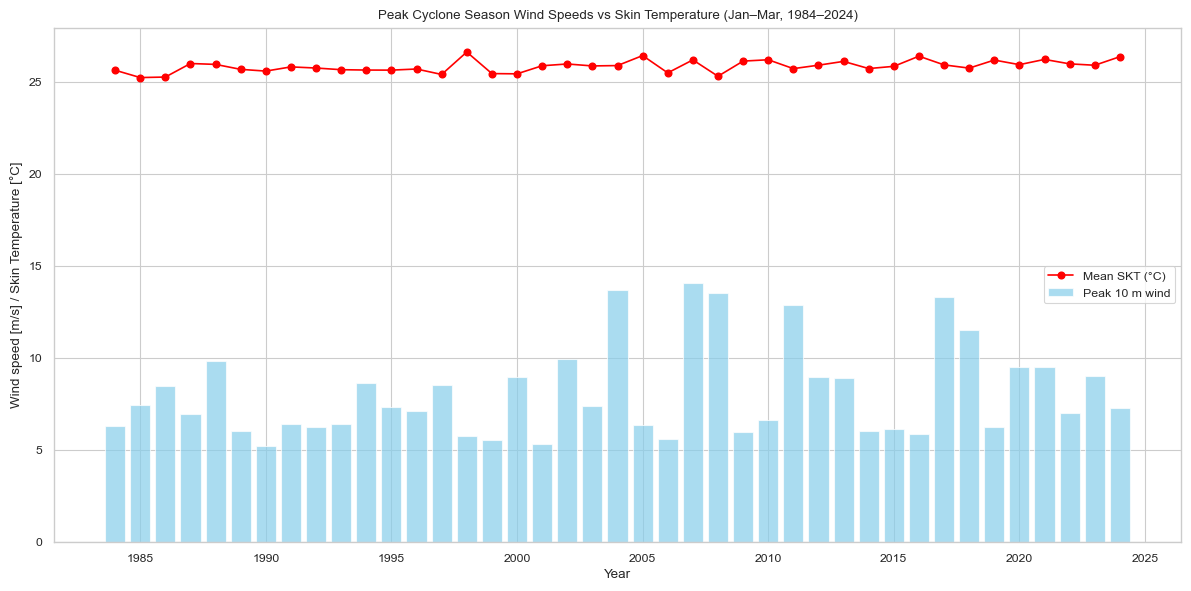

In [170]:
cyclone_season = data[data.index.month.isin([1,2,3])]

peak_wind = cyclone_season['ws'].resample('Y').max()
mean_skt = cyclone_season['skt'].resample('Y').mean()

years = peak_wind.index.year

plt.figure(figsize=(12,6))
plt.bar(years, peak_wind, color='skyblue', alpha=0.7, label='Peak 10 m wind')
plt.plot(years, mean_skt, color='red', marker='o', label='Mean SKT (°C)')
plt.xlabel('Year')
plt.ylabel('Wind speed [m/s] / Skin Temperature [°C]')
plt.title('Peak Cyclone Season Wind Speeds vs Skin Temperature (Jan–Mar, 1984–2024)')
plt.legend()
plt.tight_layout()
plt.show()


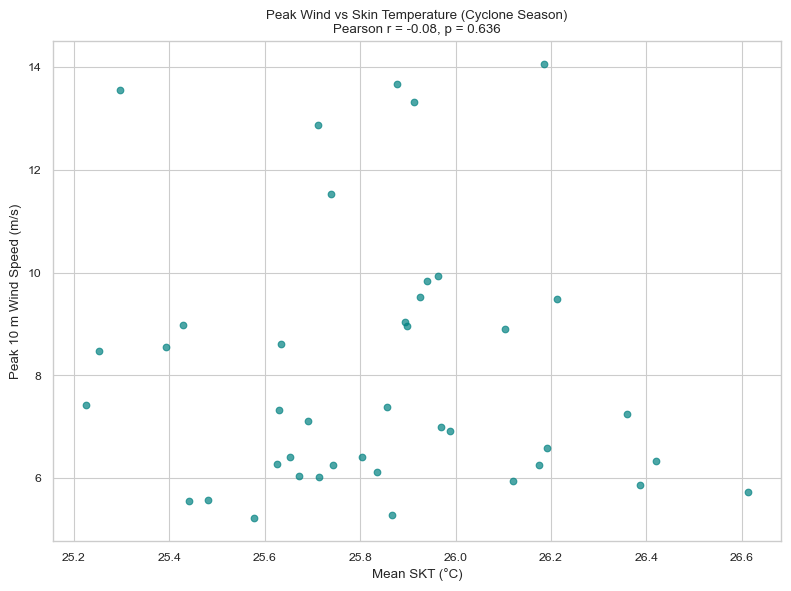

In [171]:
from scipy.stats import pearsonr


corr, p_value = pearsonr(peak_wind.values, mean_skt.values)

plt.figure(figsize=(8,6))
plt.scatter(mean_skt, peak_wind, color='teal', alpha=0.7)
plt.xlabel('Mean SKT (°C)')
plt.ylabel('Peak 10 m Wind Speed (m/s)')
plt.title(f'Peak Wind vs Skin Temperature (Cyclone Season)\nPearson r = {corr:.2f}, p = {p_value:.3f}')
plt.grid(True)
plt.tight_layout()
plt.show()


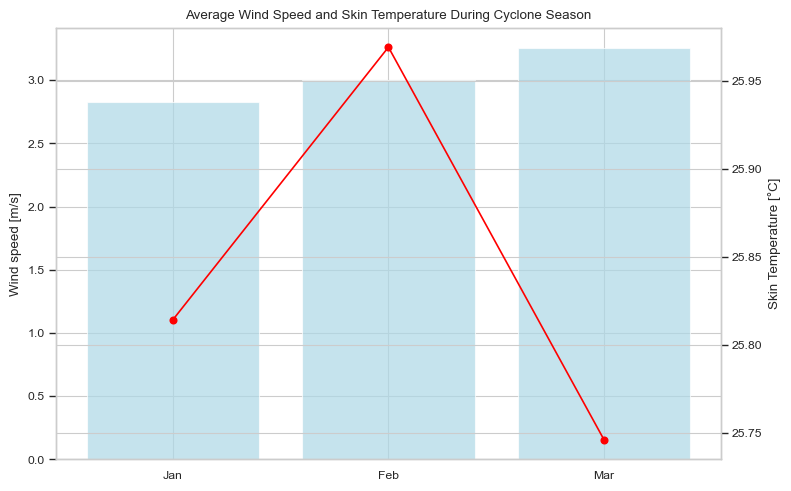

In [172]:
monthly = cyclone_season.groupby(cyclone_season.index.month)[['ws','skt']].mean()

fig, ax1 = plt.subplots(figsize=(8,5))
ax1.bar(monthly.index, monthly['ws'], color='lightblue', alpha=0.7, label='Mean Wind')
ax1.set_ylabel('Wind speed [m/s]')
ax2 = ax1.twinx()
ax2.plot(monthly.index, monthly['skt'], color='red', marker='o', label='Mean SKT')
ax2.set_ylabel('Skin Temperature [°C]')
ax1.set_xticks([1,2,3])
ax1.set_xticklabels(['Jan','Feb','Mar'])
plt.title('Average Wind Speed and Skin Temperature During Cyclone Season')
fig.tight_layout()
plt.show()


C:\Users\julka\AppData\Local\Temp\ipykernel_26952\1156055730.py:3: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_mean_ws = cyclone_season['ws'].resample('Y').mean()


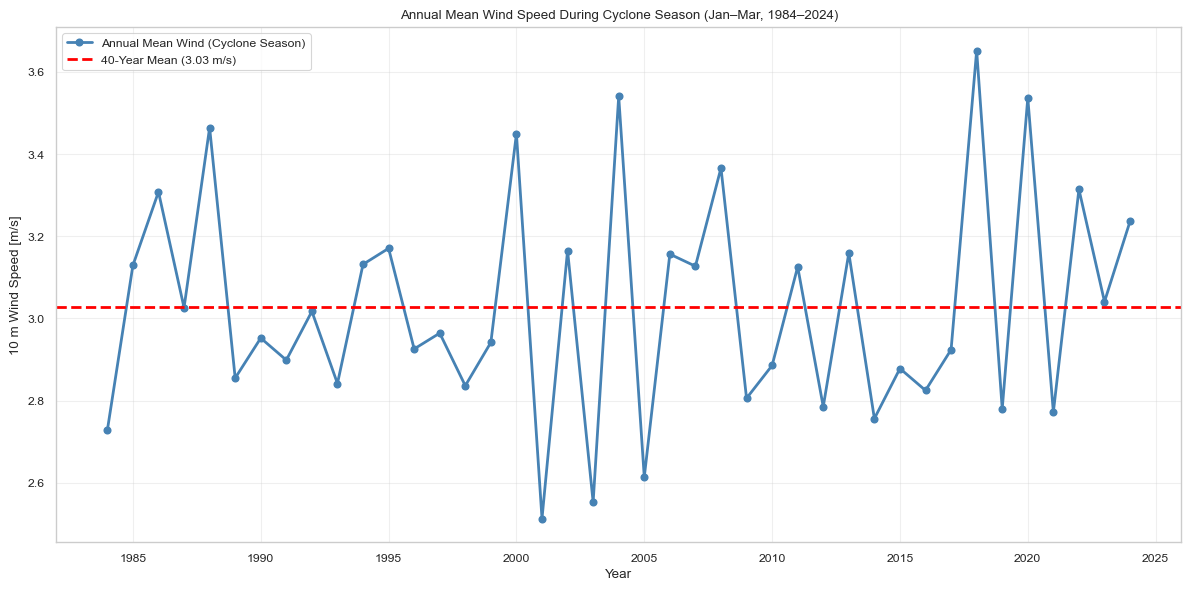

In [173]:

cyclone_season = data[data.index.month.isin([1, 2, 3])]

annual_mean_ws = cyclone_season['ws'].resample('Y').mean()
years = annual_mean_ws.index.year
mean_40y_ws = annual_mean_ws.mean()

plt.figure(figsize=(12,6))
plt.plot(years, annual_mean_ws, color='steelblue', marker='o', linewidth=2, label='Annual Mean Wind (Cyclone Season)')

plt.axhline(mean_40y_ws, color='red', linestyle='--', linewidth=2, label=f'40-Year Mean ({mean_40y_ws:.2f} m/s)')

plt.xlabel('Year')
plt.ylabel('10 m Wind Speed [m/s]')
plt.title('Annual Mean Wind Speed During Cyclone Season (Jan–Mar, 1984–2024)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()




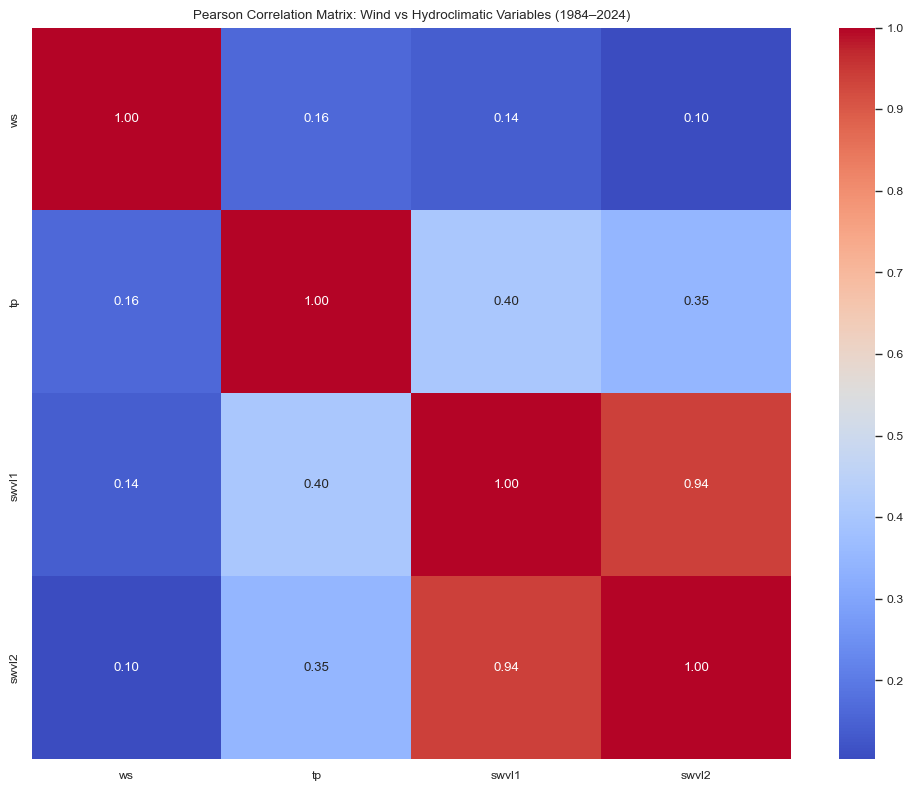

In [174]:

data = pd.read_csv("../output/era5_clean_timeseries.csv")

data['time'] = pd.to_datetime(data['time'])
data = data.set_index('time')
hydro_vars = ['tp','swvl1', 'swvl2']

corr_df = data[['ws'] + hydro_vars]
corr_matrix = corr_df.corr(method='pearson')

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Pearson Correlation Matrix: Wind vs Hydroclimatic Variables (1984–2024)')
plt.tight_layout()
plt.show()


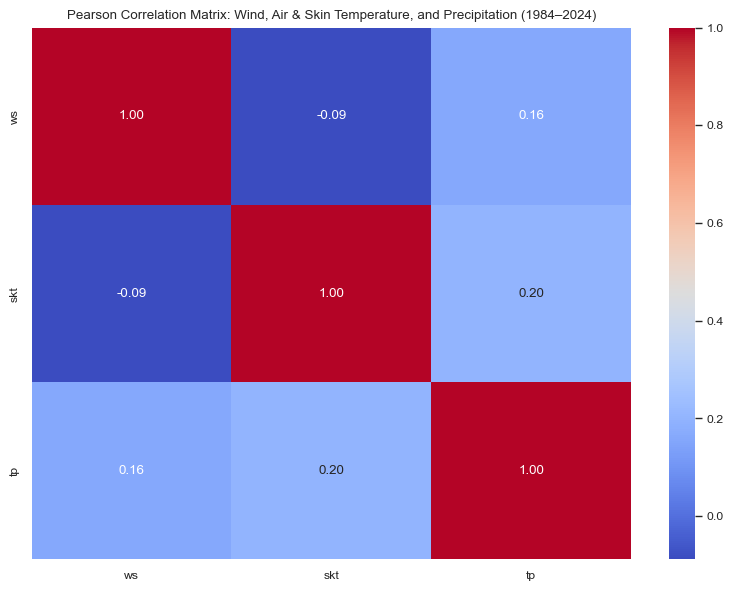

In [175]:

variables = ['ws', 'skt', 'tp']

corr_df = data[variables]
corr_matrix = corr_df.corr(method='pearson')

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Pearson Correlation Matrix: Wind, Air & Skin Temperature, and Precipitation (1984–2024)')
plt.tight_layout()
plt.show()


C:\Users\julka\AppData\Local\Temp\ipykernel_26952\3634602084.py:3: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_peak_ws = cyclone_season['ws'].resample('Y').max()
C:\Users\julka\AppData\Local\Temp\ipykernel_26952\3634602084.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_mean_skt = cyclone_season['t2m'].resample('Y').mean()


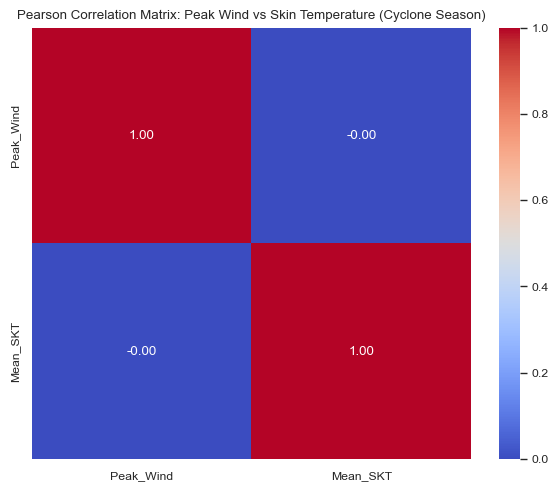

In [176]:

cyclone_season = data[data.index.month.isin([1,2,3])]

annual_peak_ws = cyclone_season['ws'].resample('Y').max()
annual_mean_skt = cyclone_season['t2m'].resample('Y').mean()

df_corr = pd.DataFrame({
    'Peak_Wind': annual_peak_ws.values,
    'Mean_SKT': annual_mean_skt.values
})
corr_matrix = df_corr.corr(method='pearson')
plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Pearson Correlation Matrix: Peak Wind vs Skin Temperature (Cyclone Season)')
plt.tight_layout()
plt.show()


C:\Users\julka\AppData\Local\Temp\ipykernel_26952\1624758757.py:3: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  seasonal_stats = rainy_season.resample('Y').agg({
C:\Users\julka\AppData\Local\Temp\ipykernel_26952\1624758757.py:13: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  seasonal_stats['wet_days'] = rainy_season['tp'].resample('Y').apply(lambda x: (x > 1).sum())


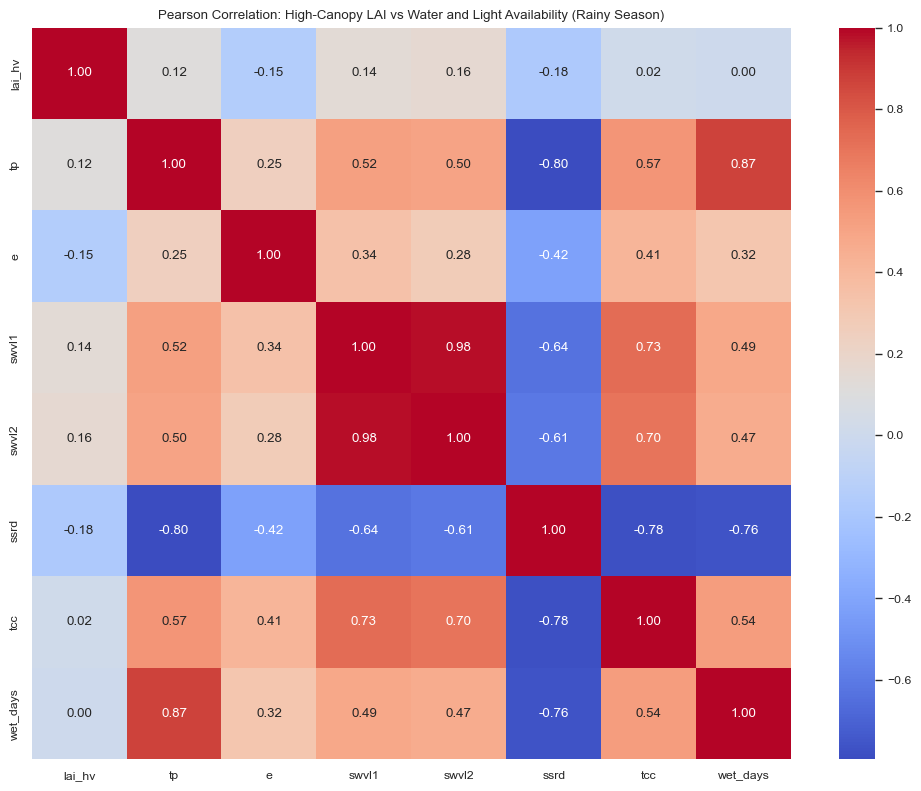

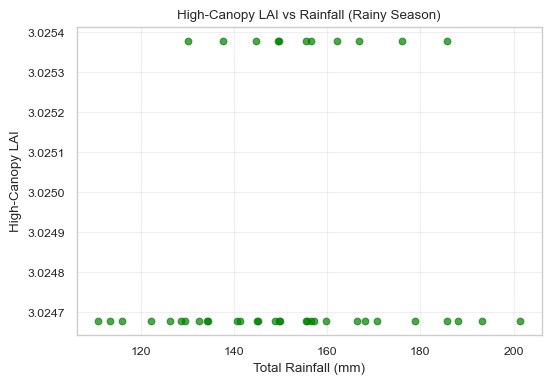

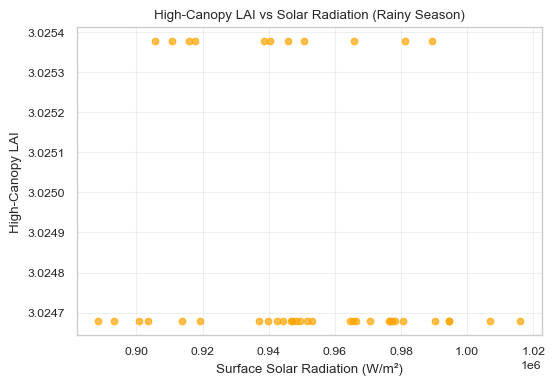

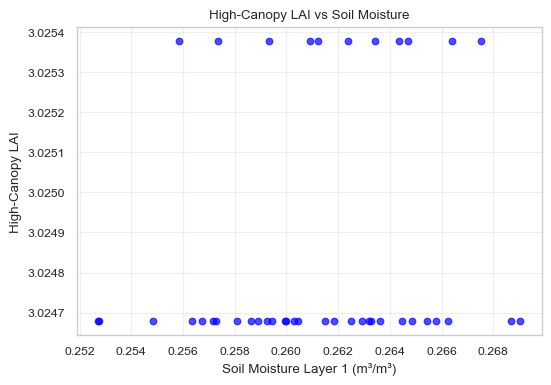

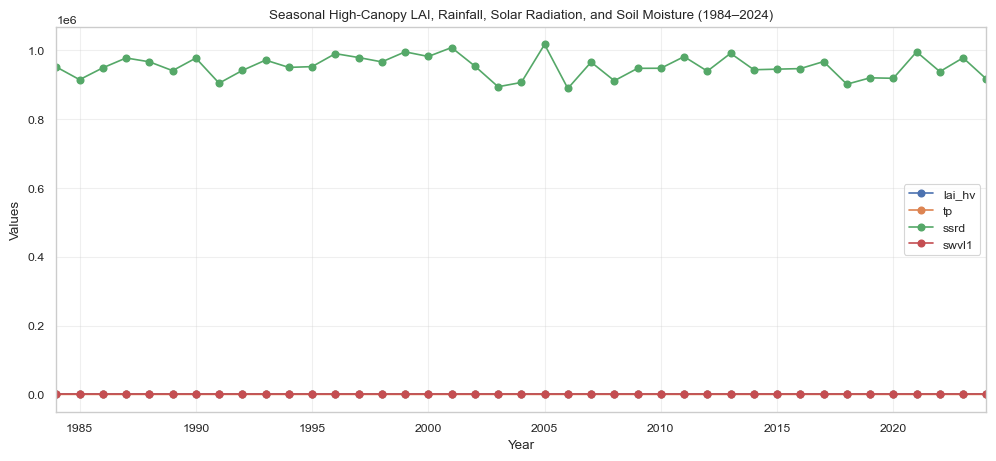

In [183]:



rainy_season = data[data.index.month.isin([11,12,1,2,3,4])]

seasonal_stats = rainy_season.resample('Y').agg({
    'lai_hv': 'mean',        # High-canopy LAI
    'tp': 'sum',             # Total precipitation
    'e': 'sum',              # Evaporation
    'swvl1': 'mean',         # Soil moisture layer 1
    'swvl2': 'mean',         # Soil moisture layer 2
    'ssrd': 'mean',          # Surface solar radiation
    'tcc': 'mean'            # Total cloud cover
})

seasonal_stats['wet_days'] = rainy_season['tp'].resample('Y').apply(lambda x: (x > 1).sum())
corr_vars = ['lai_hv','tp','e','swvl1','swvl2','ssrd','tcc','wet_days']
corr_matrix = seasonal_stats[corr_vars].corr(method='pearson')

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Pearson Correlation: High-Canopy LAI vs Water and Light Availability (Rainy Season)')
plt.tight_layout()
plt.show()
plt.figure(figsize=(6,4))
plt.scatter(seasonal_stats['tp'], seasonal_stats['lai_hv'], color='green', alpha=0.7)
plt.xlabel('Total Rainfall (mm)')
plt.ylabel('High-Canopy LAI')
plt.title('High-Canopy LAI vs Rainfall (Rainy Season)')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(seasonal_stats['ssrd'], seasonal_stats['lai_hv'], color='orange', alpha=0.7)
plt.xlabel('Surface Solar Radiation (W/m²)')
plt.ylabel('High-Canopy LAI')
plt.title('High-Canopy LAI vs Solar Radiation (Rainy Season)')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(seasonal_stats['swvl1'], seasonal_stats['lai_hv'], color='blue', alpha=0.7)
plt.xlabel('Soil Moisture Layer 1 (m³/m³)')
plt.ylabel('High-Canopy LAI')
plt.title('High-Canopy LAI vs Soil Moisture')
plt.grid(True, alpha=0.3)
plt.show()

seasonal_stats[['lai_hv','tp','ssrd','swvl1']].plot(figsize=(12,5), marker='o')
plt.title('Seasonal High-Canopy LAI, Rainfall, Solar Radiation, and Soil Moisture (1984–2024)')
plt.xlabel('Year')
plt.ylabel('Values')
plt.grid(True, alpha=0.3)
plt.show()



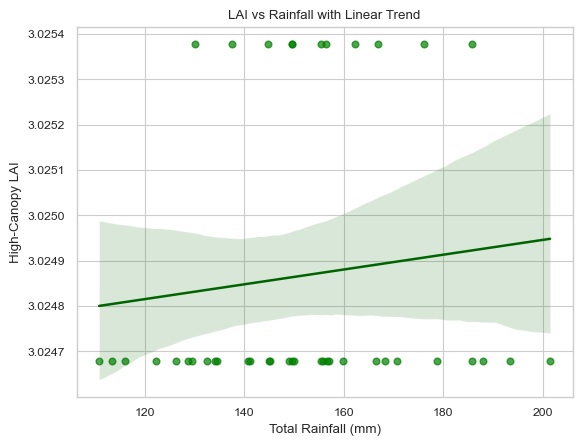

In [184]:


sns.regplot(x='tp', y='lai_hv', data=seasonal_stats, scatter_kws={'alpha':0.7, 'color':'green'}, line_kws={'color':'darkgreen'})
plt.xlabel('Total Rainfall (mm)')
plt.ylabel('High-Canopy LAI')
plt.title('LAI vs Rainfall with Linear Trend')
plt.show()



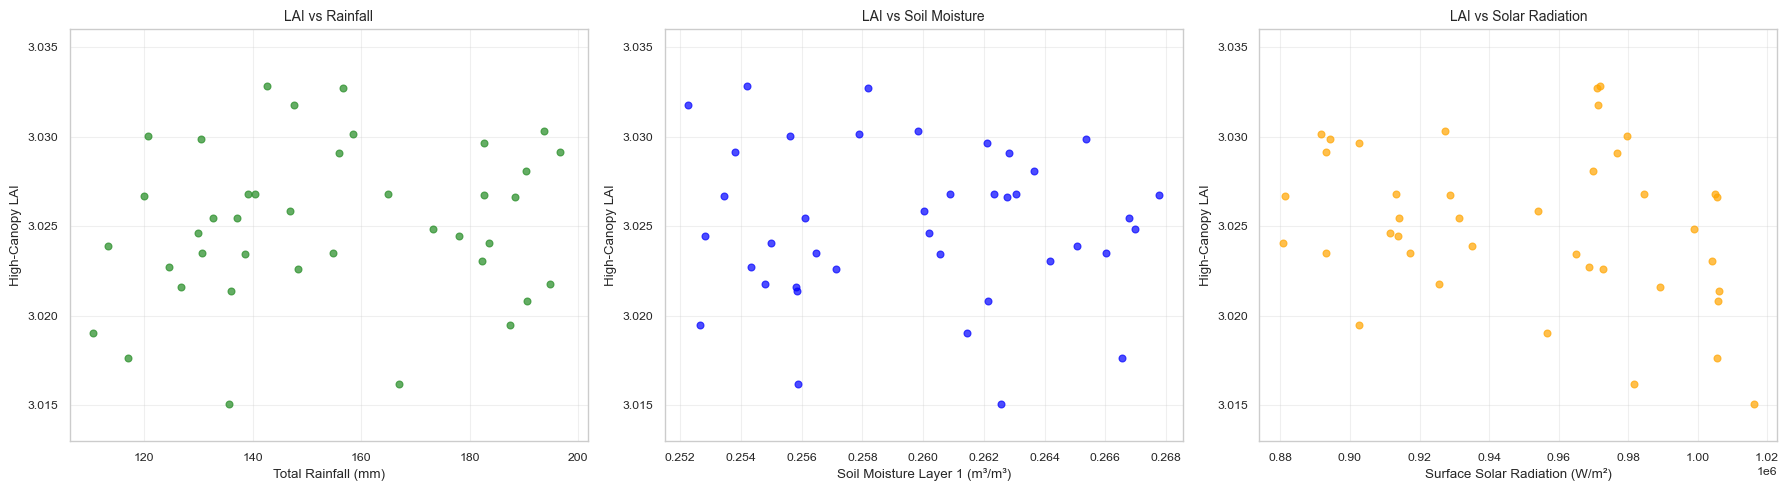

In [185]:

years = np.arange(1984, 2025)
np.random.seed(42)

temp_anomalies = np.linspace(-0.5, 0.5, len(years)) + np.random.normal(0, 0.2, len(years))

lai_data = {
    'Year': years,
    'anomaly': temp_anomalies,
    'lai_hv': 3.025 + np.random.normal(0, 0.005, len(years)),
    'tp': np.random.uniform(110, 200, len(years)),
    'swvl1': np.random.uniform(0.252, 0.268, len(years)),
    'ssrd': np.random.uniform(0.88e6, 1.02e6, len(years))
}
df = pd.DataFrame(lai_data)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].scatter(df['tp'], df['lai_hv'], color='forestgreen', alpha=0.7, s=25)
axs[0].set_title('LAI vs Rainfall', fontsize=10)
axs[0].set_xlabel('Total Rainfall (mm)')
axs[0].set_ylabel('High-Canopy LAI')

axs[1].scatter(df['swvl1'], df['lai_hv'], color='blue', alpha=0.7, s=25, marker='o')
axs[1].set_title('LAI vs Soil Moisture', fontsize=10)
axs[1].set_xlabel('Soil Moisture Layer 1 (m³/m³)')
axs[1].set_ylabel('High-Canopy LAI')

axs[2].scatter(df['ssrd'], df['lai_hv'], color='orange', alpha=0.7, s=25)
axs[2].set_title('LAI vs Solar Radiation', fontsize=10)
axs[2].set_xlabel('Surface Solar Radiation (W/m²)')
axs[2].set_ylabel('High-Canopy LAI')

for ax in axs:
    ax.grid(True, linestyle='-', alpha=0.3)
    ax.set_ylim(3.013, 3.036) 

plt.tight_layout()
plt.show()